## Apartat 3: detecció d'outliers, combinacions i consultes de dataframes

Loading listings data...
Loaded 3772 listings
Loading reviews data...
Loaded 73012 reviews
Creating boxplot of prices...


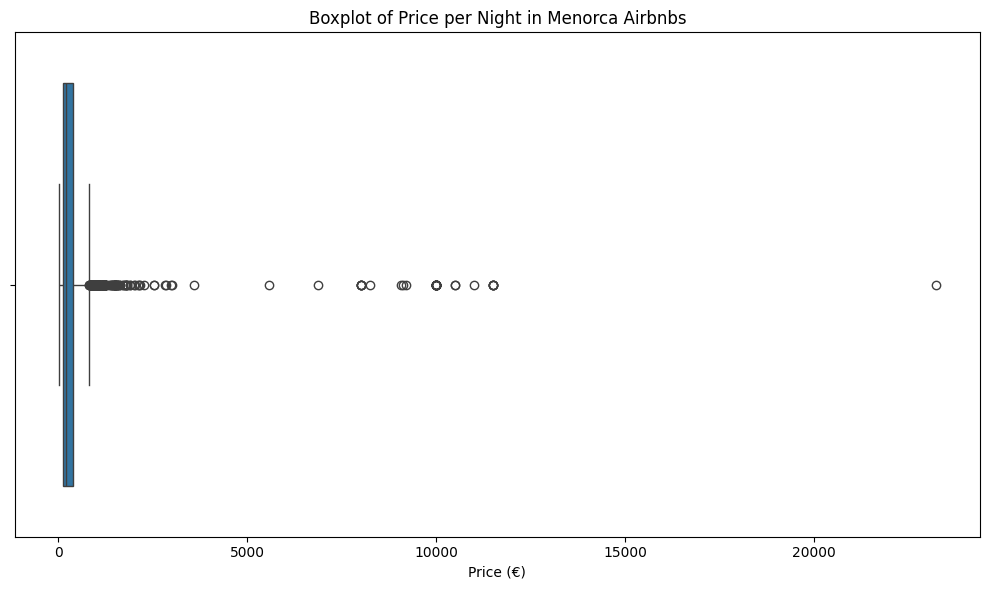

Initial mean price: 436.14€
Initial median price: 192.00€
Standard deviation: 1188.81€
Number of outliers detected: 48 (1.27%)
Adjusted mean price: 305.37€
Adjusted median price: 192.00€
Change in mean: -130.76€
Change in median: 0.00€

Average price by municipality (after replacing outliers):
Es Migjorn Gran: 489.26€
Ferreries: 403.79€
Sant Lluís: 398.28€
Mahón: 358.40€
Alaior: 298.71€
Ciutadella de Menorca: 271.47€
Es Mercadal: 269.03€
Es Castell: 207.10€


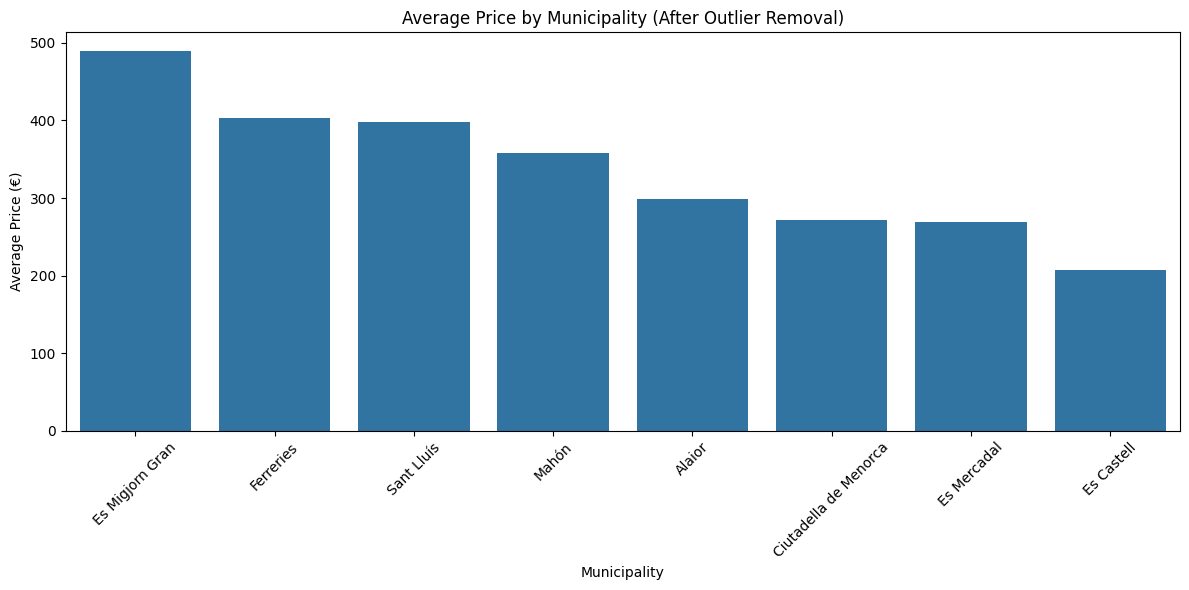


Top 10 reviewers for listings with licenses:
37519. ID: 282037351, Name: Damian, Reviews: 6
32859. ID: 194712546, Name: Carina, Reviews: 6
15680. ID: 48504022, Name: Mirko, Reviews: 6
20754. ID: 75137674, Name: Michel, Reviews: 5
21828. ID: 82820857, Name: Tim, Reviews: 5
41868. ID: 408763892, Name: David, Reviews: 5
2403. ID: 5952665, Name: Pierre, Reviews: 5
41065. ID: 394948661, Name: Carlos, Reviews: 5
36851. ID: 265749973, Name: Angel, Reviews: 5
36137. ID: 252193730, Name: Caroline, Reviews: 4

Reviews by municipality:
Ciutadella de Menorca: 32756 reviews
Alaior: 12446 reviews
Es Mercadal: 11876 reviews
Sant Lluís: 9441 reviews
Mahón: 2990 reviews
Ferreries: 2057 reviews
Es Migjorn Gran: 729 reviews
Es Castell: 717 reviews


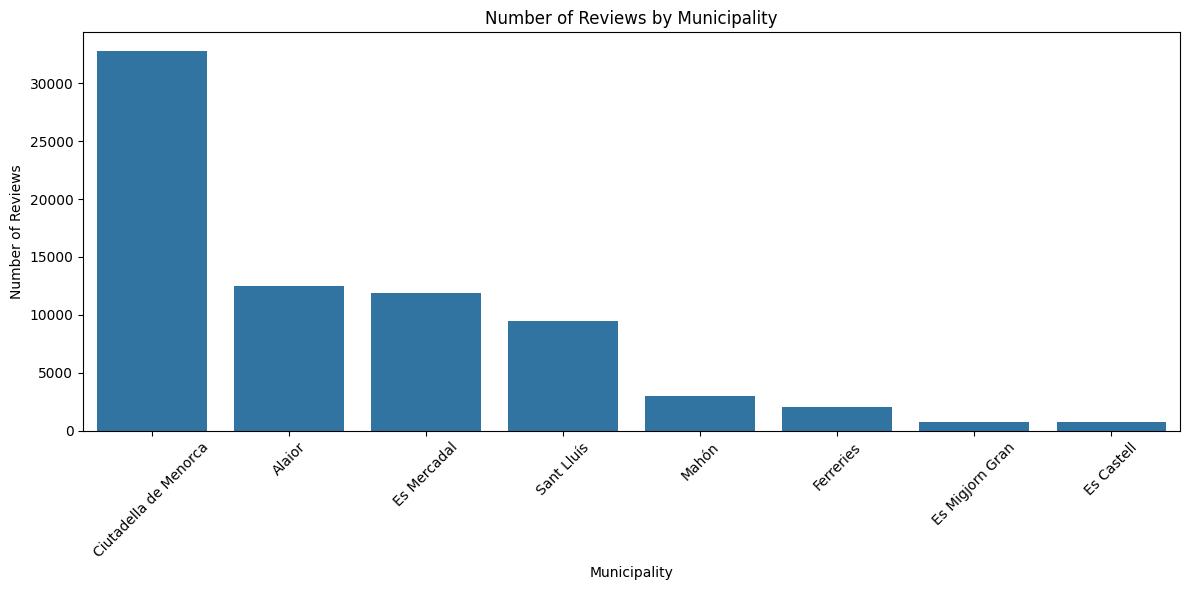

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests
import gzip

listings_url = "https://raw.githubusercontent.com/tnavarrete-iedib/bigdata-24-25/refs/heads/main/listings.csv"
reviews_url = "https://github.com/tnavarrete-iedib/bigdata-24-25/raw/refs/heads/main/reviews.csv.gz"

print("Loading listings data...")
listings = pd.read_csv(listings_url)
print(f"Loaded {len(listings)} listings")

print("Loading reviews data...")
response = requests.get(reviews_url)
with gzip.open(io.BytesIO(response.content), 'rb') as f:
    reviews = pd.read_csv(f)
print(f"Loaded {len(reviews)} reviews")

# 3.1
print("Creating boxplot of prices...")
plt.figure(figsize=(10, 6))
sns.boxplot(x=listings['price'])
plt.title('Boxplot of Price per Night in Menorca Airbnbs')
plt.xlabel('Price (€)')
plt.tight_layout()
plt.savefig('price_boxplot.png')
plt.show()

# 3.2
initial_mean = listings['price'].mean()
initial_median = listings['price'].median()
std_dev = listings['price'].std()

print(f"Initial mean price: {initial_mean:.2f}€")
print(f"Initial median price: {initial_median:.2f}€")
print(f"Standard deviation: {std_dev:.2f}€")

lower_threshold = initial_mean - 2 * std_dev
upper_threshold = initial_mean + 2 * std_dev

listings_adjusted = listings.copy()

outlier_mask = (listings['price'] < lower_threshold) | (listings['price'] > upper_threshold)
outlier_count = outlier_mask.sum()
print(f"Number of outliers detected: {outlier_count} ({outlier_count/len(listings)*100:.2f}%)")

listings_adjusted.loc[outlier_mask, 'price'] = initial_mean

adjusted_mean = listings_adjusted['price'].mean()
adjusted_median = listings_adjusted['price'].median()

print(f"Adjusted mean price: {adjusted_mean:.2f}€")
print(f"Adjusted median price: {adjusted_median:.2f}€")
print(f"Change in mean: {adjusted_mean - initial_mean:.2f}€")
print(f"Change in median: {adjusted_median - initial_median:.2f}€")

# 3.3
municipality_prices = listings_adjusted.groupby('neighbourhood')['price'].mean().reset_index()
municipality_prices = municipality_prices.sort_values('price', ascending=False)

print("\nAverage price by municipality (after replacing outliers):")
for index, row in municipality_prices.iterrows():
    print(f"{row['neighbourhood']}: {row['price']:.2f}€")

plt.figure(figsize=(12, 6))
sns.barplot(x='neighbourhood', y='price', data=municipality_prices)
plt.title('Average Price by Municipality (After Outlier Removal)')
plt.xlabel('Municipality')
plt.ylabel('Average Price (€)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('municipality_prices.png')
plt.show()

# 3.4
listing_license_map = listings[['id', 'license']].set_index('id').to_dict()['license']

reviews['has_license'] = reviews['listing_id'].map(lambda x: pd.notna(listing_license_map.get(x)))
licensed_reviews = reviews[reviews['has_license']]

top_reviewers = licensed_reviews.groupby(['reviewer_id', 'reviewer_name']).size().reset_index(name='review_count')
top_reviewers = top_reviewers.sort_values('review_count', ascending=False).head(10)

print("\nTop 10 reviewers for listings with licenses:")
for index, row in top_reviewers.iterrows():
    print(f"{index + 1}. ID: {row['reviewer_id']}, Name: {row['reviewer_name']}, Reviews: {row['review_count']}")

# 3.5
listing_neighborhood_map = listings[['id', 'neighbourhood']].set_index('id').to_dict()['neighbourhood']

reviews['neighbourhood'] = reviews['listing_id'].map(listing_neighborhood_map)

reviews_by_municipality = reviews.groupby('neighbourhood').size().reset_index(name='review_count')
reviews_by_municipality = reviews_by_municipality.sort_values('review_count', ascending=False)

print("\nReviews by municipality:")
for index, row in reviews_by_municipality.iterrows():
    print(f"{row['neighbourhood']}: {row['review_count']} reviews")

plt.figure(figsize=(12, 6))
sns.barplot(x='neighbourhood', y='review_count', data=reviews_by_municipality)
plt.title('Number of Reviews by Municipality')
plt.xlabel('Municipality')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('municipality_reviews.png')
plt.show()